In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [2]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [3]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

# API Calls

In [4]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [5]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

#### Serial

In [99]:
%timeit -n 1 [download(url, 1) for url in urls]

1 loop, best of 3: 6.36 s per loop


#### Multithreading

5.8347444534301758

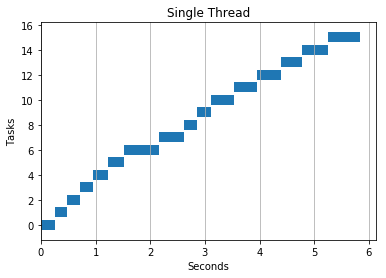

In [124]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

3.7525379657745361

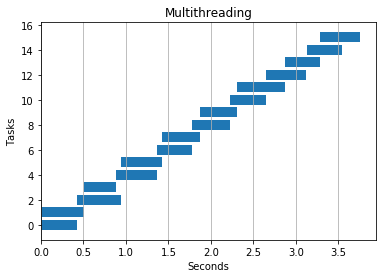

In [8]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

2.0224919319152832

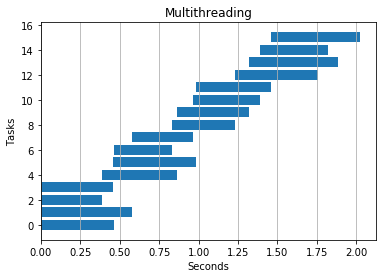

In [9]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

#### Multiprocessing

6.8083174228668213

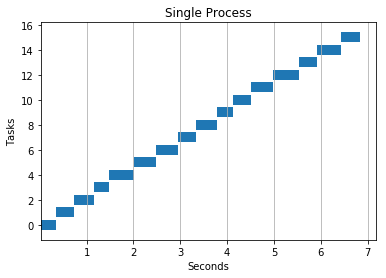

In [121]:
visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")

3.5206444263458252

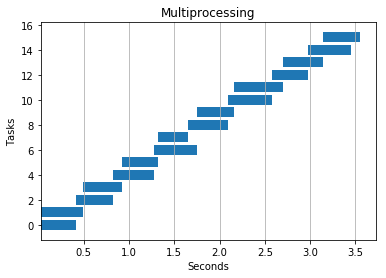

In [11]:
visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)

2.1228179931640625

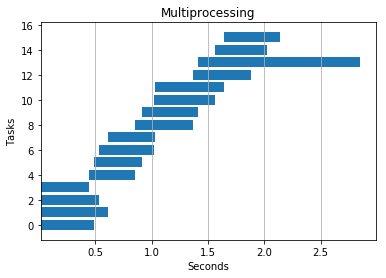

In [12]:
visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)

# IO Heavy

In [103]:
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [104]:
N=12
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**7*5))

#### Serial

In [15]:
%timeit -n 1 [io_heavy(TEXT,1) for i in range(N)]

1 loop, best of 3: 1.37 s per loop


#### Multithreading

Should see good benefit from this

1.2725670337677002

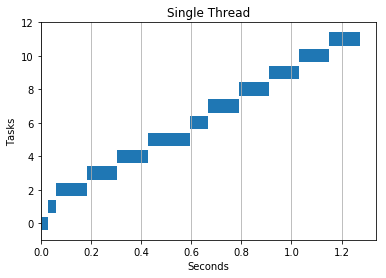

In [105]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 1),"Single Thread")

0.68187546730041504

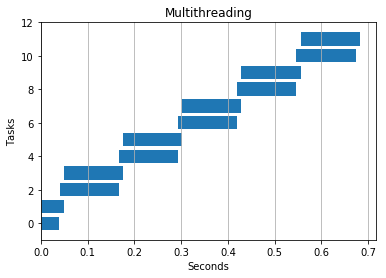

In [17]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)

0.59884214401245117

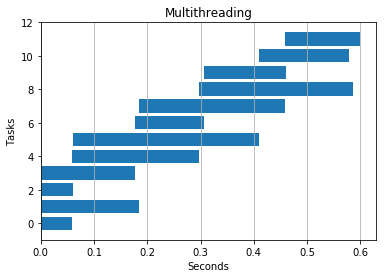

In [18]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Should see good benefit from this

1.3357248306274414

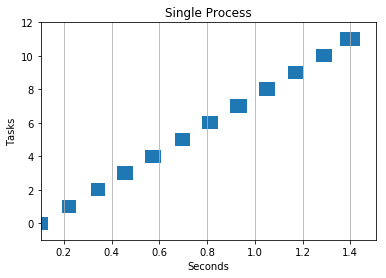

In [106]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 1),"Single Process")

0.9419243335723877

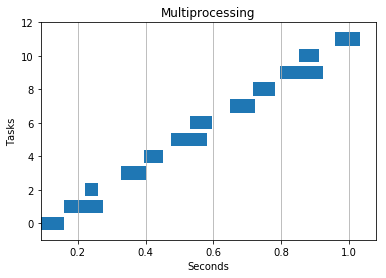

In [20]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 2),MULTIPROCESSING_TITLE)

0.89698147773742676

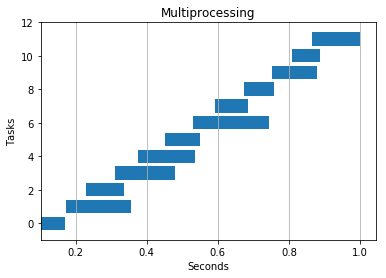

In [21]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 4),MULTIPROCESSING_TITLE)

# Numpy Functions

### Numpy Addition

In [109]:
#Does not use parallel processing by default
#But will see speedups if multiprocessing used
#Because numpy sidesteps python's GIL
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

In [110]:
DIMS = 20000
N = 20
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [24]:
%timeit -n 1 [addition(i, time.time()) for i in range(N)]

1 loop, best of 3: 14.9 s per loop


#### Multithreading

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

14.84851598739624

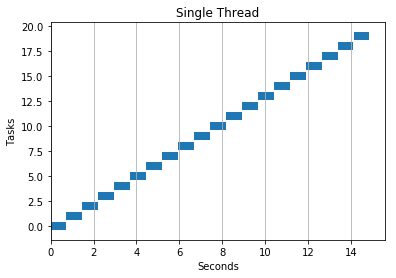

In [111]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 1),"Single Thread")

11.119851350784302

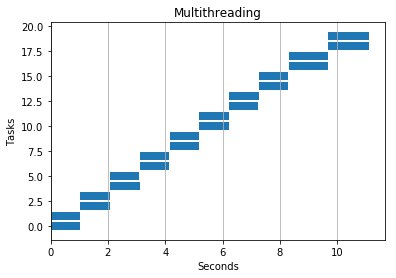

In [26]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 2),MULTITHREADING_TITLE)

16.048599004745483

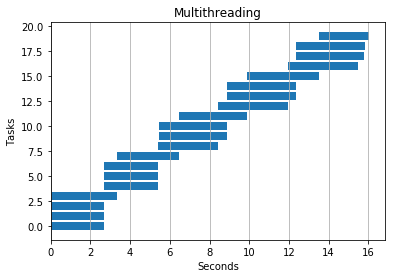

In [27]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

14.817286252975464

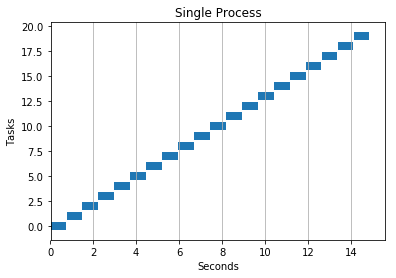

In [112]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),"Single Process")

14.861897945404053

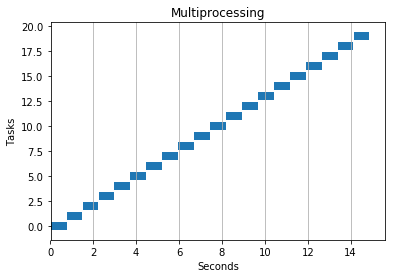

In [30]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),MULTIPROCESSING_TITLE)

14.71403169631958

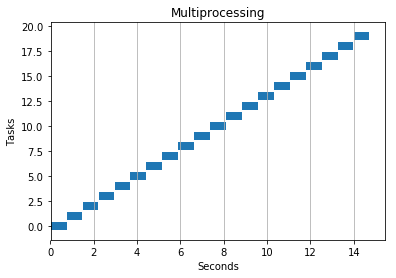

In [31]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),MULTIPROCESSING_TITLE)

### Dot Product

In [113]:
#Automatic parallel processing built works out of the box
#Depending on BLAS impl, MKL (default with anaconda3) does
#Should NOT see speedups with multithreading/processing
def dot_product(i, base):
    start = time.time() - base
    res = np.dot(a,b)
    stop = time.time() - base
    return start,stop

DIMS = 3000
N = 10
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [33]:
%timeit -n 1 [dot_product(i, time.time()) for i in range(N)]

1 loop, best of 3: 2.87 s per loop


#### Multithreading

No benefit on dot product (since already parallel)

4.197455883026123

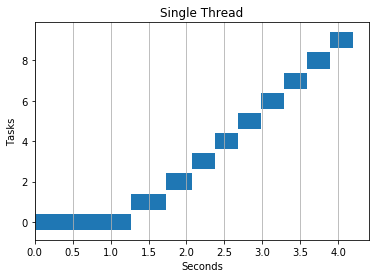

In [114]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 1),"Single Thread")

3.3708603382110596

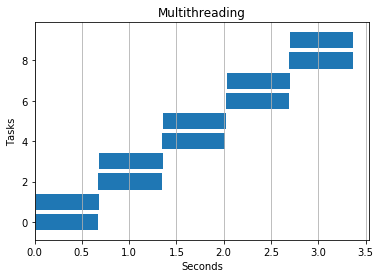

In [35]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 2),MULTITHREADING_TITLE)

3.5823237895965576

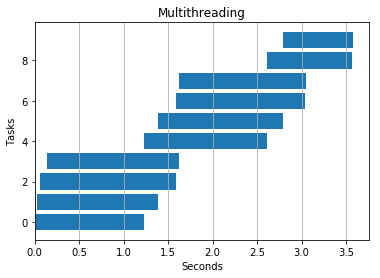

In [36]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

No benefit on dot product (since already parallel)

3.1076877117156982

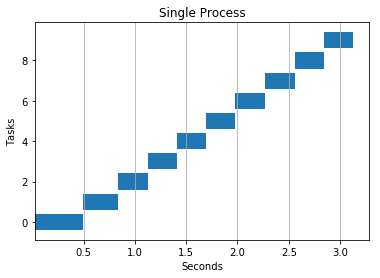

In [115]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 1),"Single Process")

3.2974824905395508

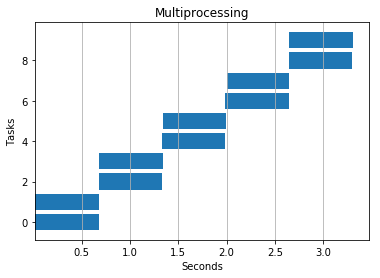

In [38]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)

3.5308358669281006

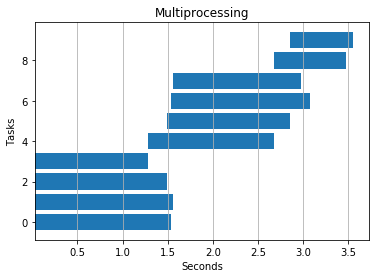

In [39]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)

### CPU Intensive

In [116]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [117]:
N = 10**7
ITERS = 10

#### Serial

In [42]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

1 loop, best of 3: 4.22 s per loop


#### Multithreading

No benefit on CPU-intensive tasks

3.9721176624298096

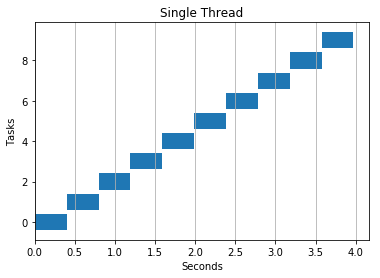

In [118]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 1),"Single Thread")

6.8206055164337158

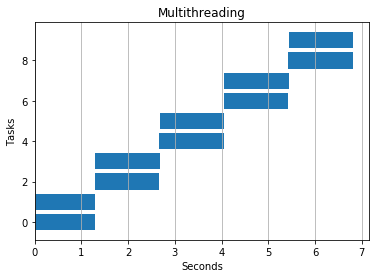

In [44]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

6.4440646171569824

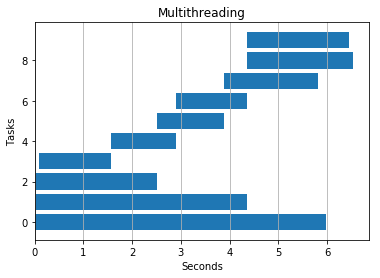

In [45]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Shows benefits on CPU-intensive tasks

3.9965052604675293

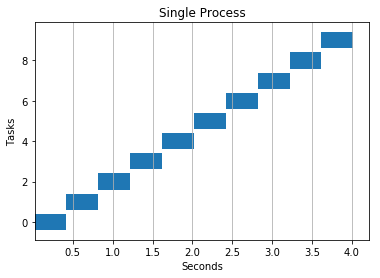

In [119]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 1),"Single Process")

4.5963289737701416

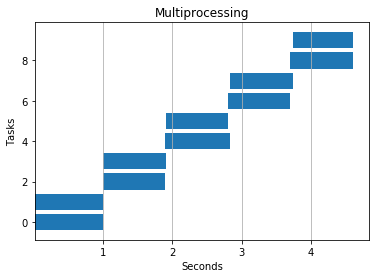

In [47]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 2),MULTIPROCESSING_TITLE)

1.8979084491729736

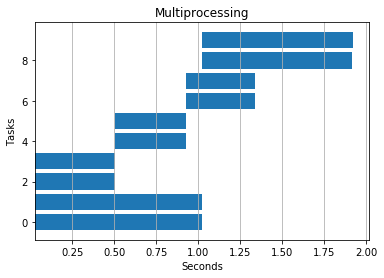

In [48]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 4),MULTIPROCESSING_TITLE)

# Resize Images

* https://github.com/python-pillow/Pillow/blob/c9f54c98a5dc18685a9bf8c8822f770492a796d6/_imagingtk.c

In [76]:
#This one takes IO so multithreading might be better?
def resize_img(fpath, base):
    img = Image.open(fpath)
    rimg = img.resize((224,224))
    img.close()
    return rimg

In [85]:
DATA_PATH='/home/bfortuner/workplace/data/imagenet_sample/'
fnames = list(glob.iglob(DATA_PATH+'*/*.JPEG'))
N = 5000

#### Serial

In [86]:
%timeit -n 1 [resize_img(f,1) for f in fnames[:N]]

1 loop, best of 3: 14.1 s per loop


#### Multithreading

In [87]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 2)

1 loop, best of 3: 7.57 s per loop


In [88]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 4)

1 loop, best of 3: 4.01 s per loop


In [89]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 8)

1 loop, best of 3: 3.26 s per loop


#### Multiprocessing

In [90]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 2)

1 loop, best of 3: 7.93 s per loop


In [91]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 4)

1 loop, best of 3: 5.02 s per loop


In [92]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 8)

1 loop, best of 3: 4.21 s per loop
